In [43]:
%load_ext autoreload
%autoreload 2

In [53]:
from pathlib import Path
import numpy as np

import rasterio
from rasterio import features
import matplotlib.pyplot as plt
import geopandas as gpd

from gridfinder.check import accuracy
from gridfinder._util import save_raster

# Filter dist results to grid guess

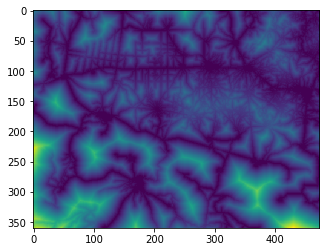

In [46]:
dists_in = 'tanzania/dists.tif'
dists_rd = rasterio.open(dists_in)
dists_r = dists_rd.read(1)
plt.imshow(dists_r, cmap='viridis')

In [47]:
dists_r

array([[22.627413, 22.2132  , 21.798986, ...,  0.      ,  0.      ,
         0.      ],
       [22.2132  , 21.2132  , 20.798986, ...,  0.      ,  0.      ,
         0.      ],
       [21.798986, 20.798986, 19.798986, ...,  1.      ,  0.      ,
         0.      ],
       ...,
       [43.382366, 42.96815 , 42.553936, ..., 31.828426, 32.028427,
        32.442642],
       [44.382366, 43.96815 , 43.553936, ..., 32.828426, 33.028427,
        33.442642],
       [45.382366, 44.96815 , 44.553936, ..., 33.828426, 34.028427,
        34.442642]], dtype=float32)

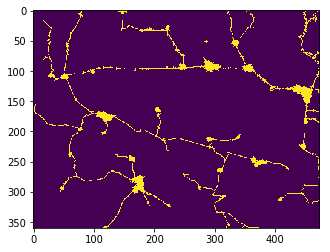

In [51]:
is_grid_cutoff = 0.5
grid_guess = np.empty_like(dists_r)
grid_guess[:] = dists_r[:]

grid_guess[dists_r >= is_grid_cutoff] = 0
grid_guess[dists_r < is_grid_cutoff] = 1
plt.imshow(grid_guess, cmap='viridis')

In [54]:
save_raster('tanzania/dists-0.5.tif', grid_guess, dists_rd.transform)

# Check results

In [2]:
grid_in = Path.home() / 'Work/Tanzania/Data/tz_grid.gpkg'
guesses_in = 'tanzania/dists-0.5.tif'
aoi_in = Path('tanzania/aoi.gpkg')

true_pos, false_neg = accuracy(grid_in, guesses_in, aoi_in)

In [3]:
print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')

Points identified as grid that are grid: 78%


In [4]:
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

Actual grid that was missed: 33%


# Convert to geometry

In [9]:
guesses_rd = rasterio.open(guesses_in)
guesses_r = guesses_rd.read(1)
guesses_r

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

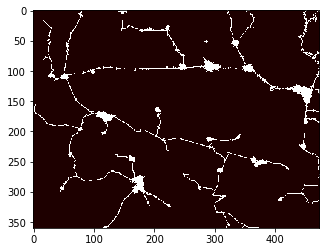

In [11]:
plt.imshow(guesses_r, cmap='pink')

In [12]:
transform = guesses_rd.transform
transform

Affine(0.0013888818565400832, 0.0, 36.24375,
       0.0, -0.001388888888888889, -5.95208)

In [33]:
geojson = {
    'type': 'FeatureCollection',
    'features': []
}

features_out = features.shapes(guesses_r, transform=transform)
for f, v in features_out:    
    geojson['features'].append({
        'type': 'Feature',
        'properties': {
            'val': v
        },
        'geometry': f
    })

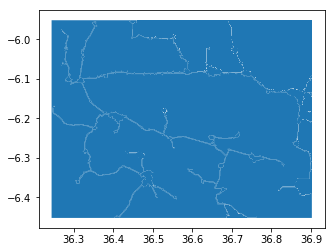

In [34]:
guesses_vec = gpd.GeoDataFrame.from_features(geojson, crs={'init': 'epsg:4326'})
guesses_vec.plot()

In [35]:
guesses_vec.head()

,geometry,val
0,"POLYGON ((36.67569225738396 -5.95208, 36.67569...",0.0
1,"POLYGON ((36.87013571729958 -5.95208, 36.87013...",1.0
2,"POLYGON ((36.89652447257384 -5.95208, 36.89652...",1.0
3,POLYGON ((36.86874683544303 -5.954857777777778...,1.0
4,"POLYGON ((36.8951355907173 -5.954857777777778,...",1.0


In [38]:
guesses_vec = guesses_vec.loc[guesses_vec['val'] == 1]
guesses_vec.head()

,geometry,val
1,"POLYGON ((36.87013571729958 -5.95208, 36.87013...",1.0
2,"POLYGON ((36.89652447257384 -5.95208, 36.89652...",1.0
3,POLYGON ((36.86874683544303 -5.954857777777778...,1.0
4,"POLYGON ((36.8951355907173 -5.954857777777778,...",1.0
5,POLYGON ((36.89374670886076 -5.956246666666666...,1.0


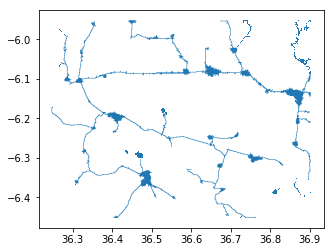

In [40]:
guesses_vec.plot()

In [42]:
guesses_vec.to_file('tanzania/grid_created.gpkg', driver='GPKG')

/home/chris/anaconda3/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
CPLE_NotSupported in driver GPKG does not support creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/Code/gridfinder/tanzania/grid_created.gpkg does not support layer creation option ENCODING
CPLE_NotSupported in dataset /home/chris/Documents/Code/gridfinder/tanzania/grid_created.gpkg does not support layer creation option ENCODING
